In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import cv2

from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from os import makedirs
from os.path import expanduser, exists, join

Using TensorFlow backend.


In [2]:
train_folder = 'train/'
test_folder = 'train/'

In [3]:
train_dogs = pd.read_csv('labels.csv')
train_dogs.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


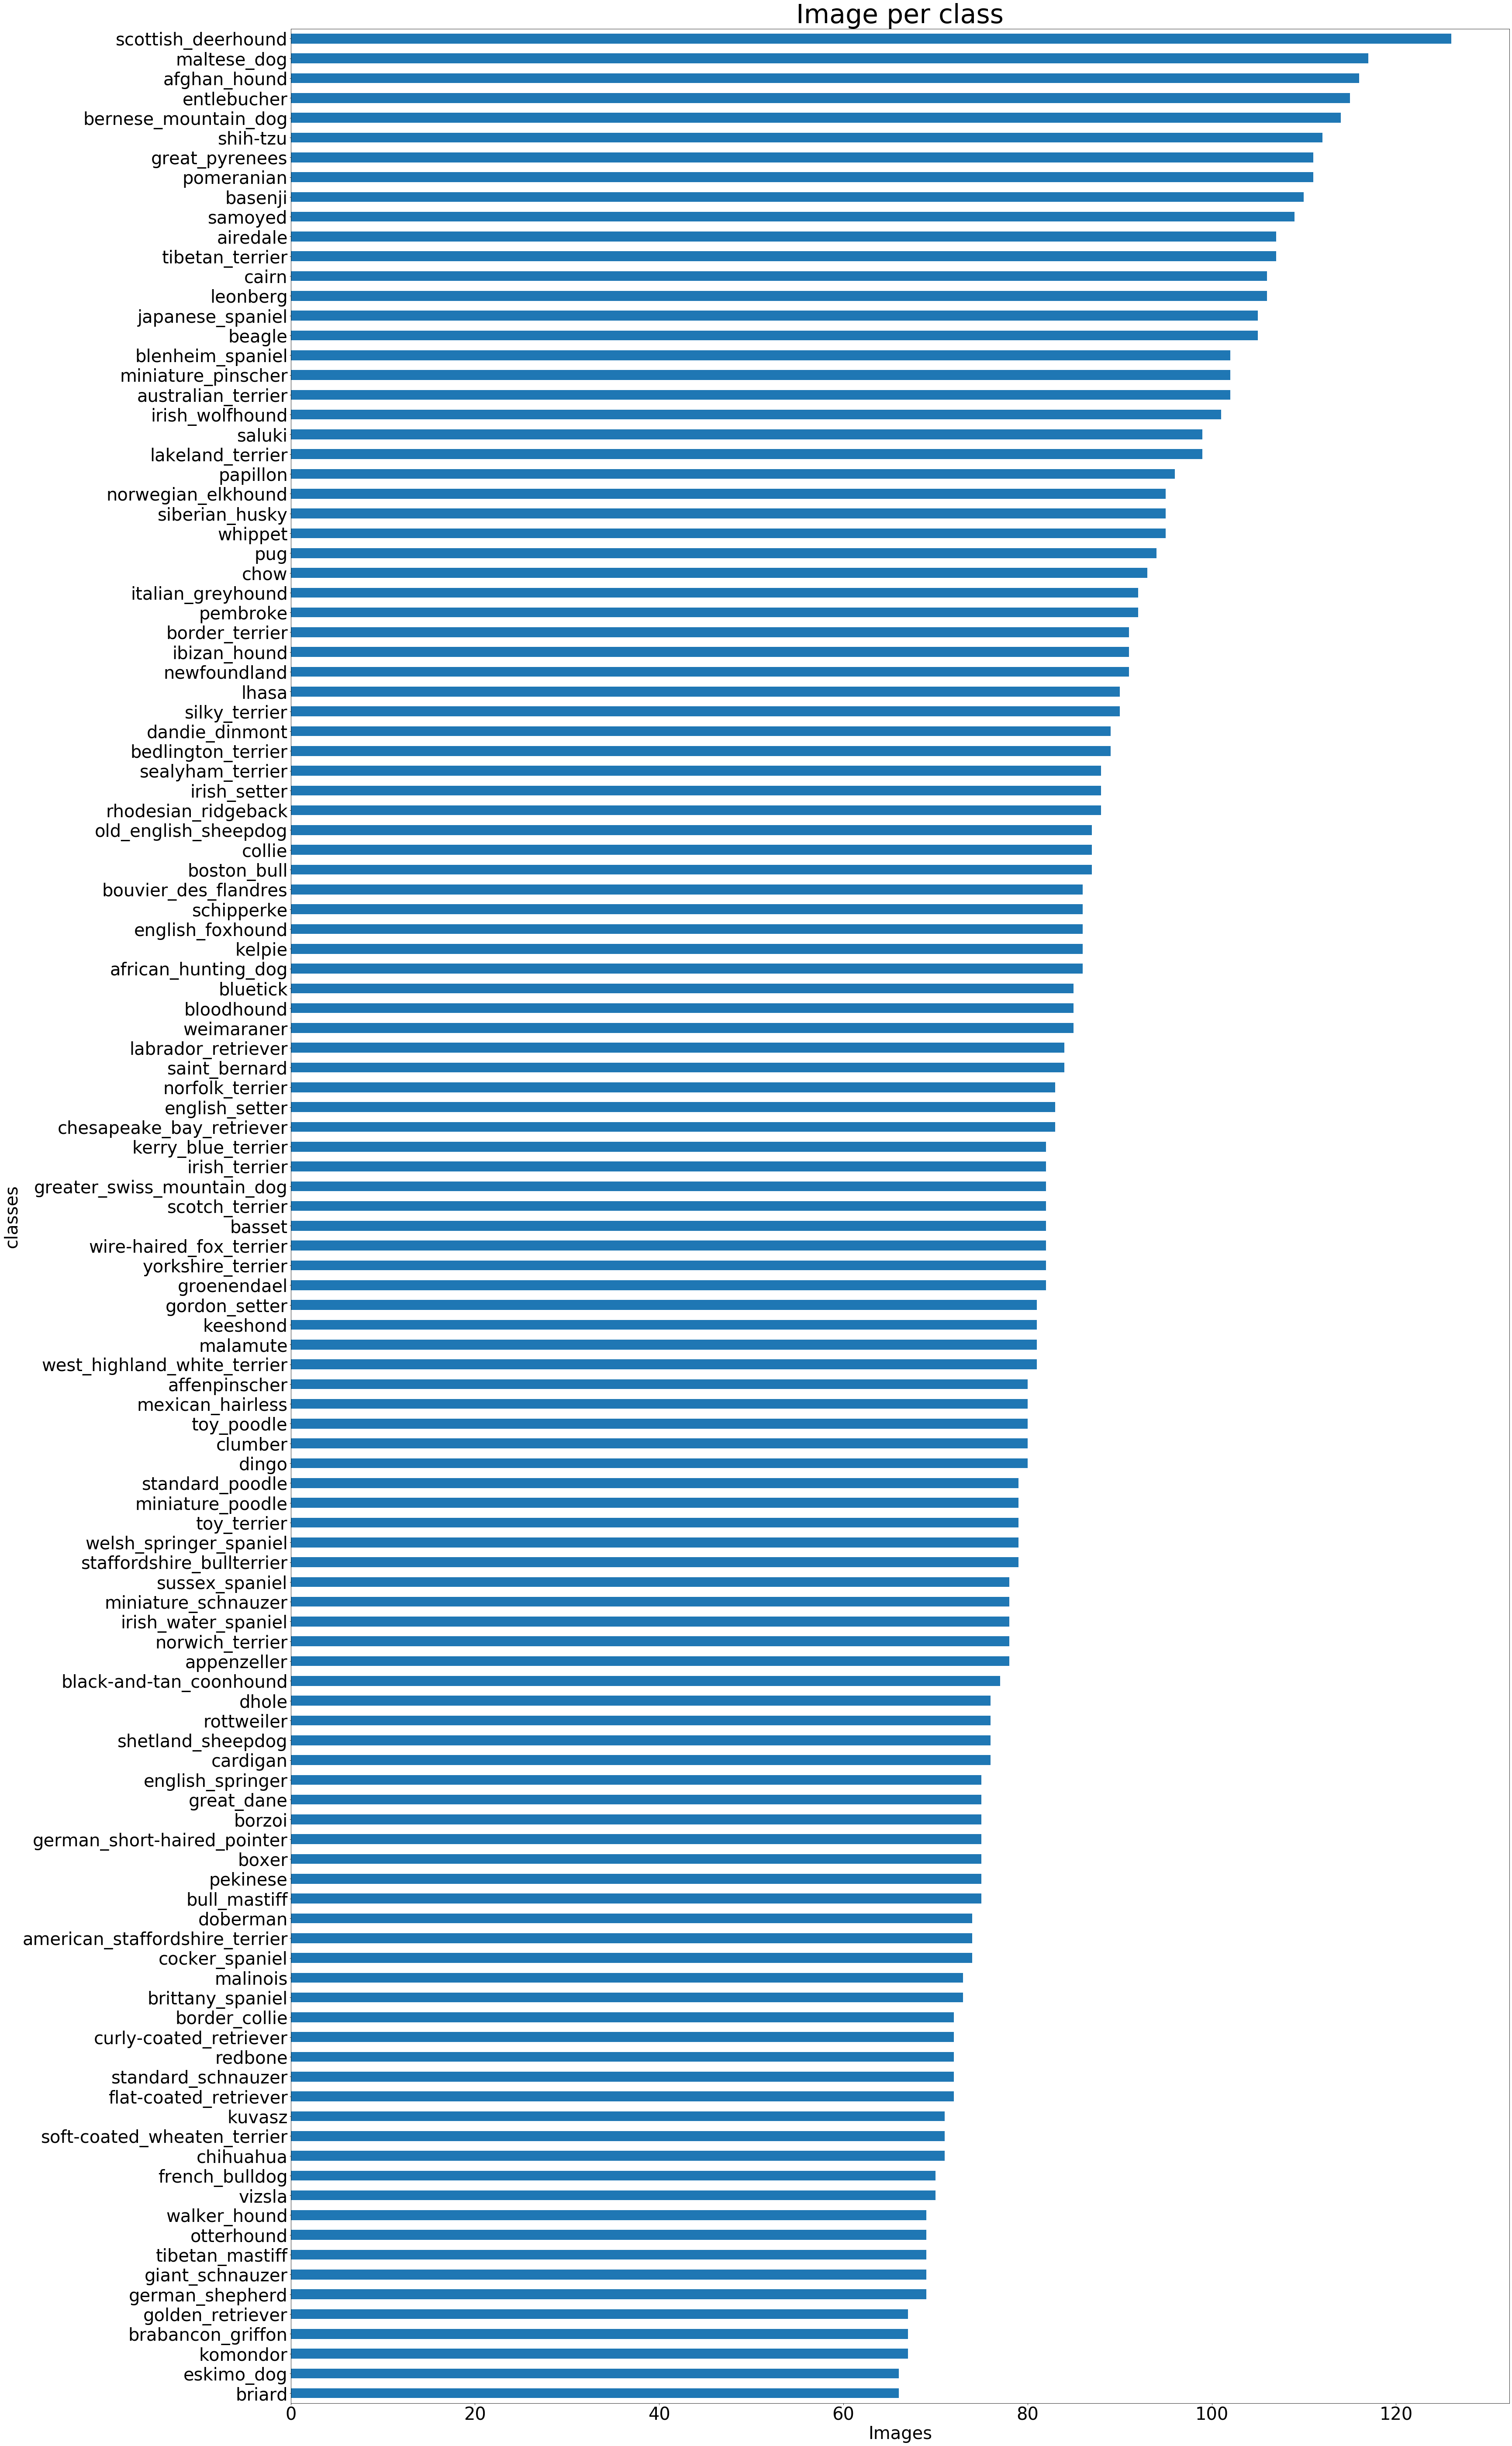

In [4]:
#graph specifying images per class
ax = pd.value_counts(train_dogs['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Image per class",figsize=(50,100))
ax.set(xlabel="Images", ylabel="classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [5]:
top_breeds = sorted(list(train_dogs['breed'].value_counts().head(50).index))
train_dogs=train_dogs[train_dogs['breed'].isin(top_breeds)]

In [6]:
print(top_breeds)
train_dogs.shape
target_labels = train_dogs['breed']

['afghan_hound', 'african_hunting_dog', 'airedale', 'australian_terrier', 'basenji', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_terrier', 'boston_bull', 'bouvier_des_flandres', 'cairn', 'chow', 'collie', 'dandie_dinmont', 'english_foxhound', 'entlebucher', 'great_pyrenees', 'ibizan_hound', 'irish_setter', 'irish_wolfhound', 'italian_greyhound', 'japanese_spaniel', 'kelpie', 'lakeland_terrier', 'leonberg', 'lhasa', 'maltese_dog', 'miniature_pinscher', 'newfoundland', 'norwegian_elkhound', 'old_english_sheepdog', 'papillon', 'pembroke', 'pomeranian', 'pug', 'rhodesian_ridgeback', 'saluki', 'samoyed', 'schipperke', 'scottish_deerhound', 'sealyham_terrier', 'shih-tzu', 'siberian_husky', 'silky_terrier', 'tibetan_terrier', 'whippet']


In [7]:
one_hot=pd.get_dummies(target_labels, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [8]:
train_dogs['image_path'] = train_dogs.apply( lambda x:(train_folder + x["id"] + ".jpg"), axis=1)
train_dogs.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,train/002211c81b498ef88e1b40b9abf84e1d.jpg
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,train/00290d3e1fdd27226ba27a8ce248ce85.jpg
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,train/003df8b8a8b05244b1d920bb6cf451f9.jpg


In [9]:
#convert images to arrays which will be use in model.
train_data = np.array([img_to_array(load_img(img, target_size=(299,299))) for img in train_dogs['image_path'].values.tolist()])

In [10]:
#split the data into train and validation.

x_train, x_validation, y_train, y_validation = train_test_split(train_data, target_labels, test_size=0.2, stratify = np.array(target_labels), random_state=100)

In [11]:
print('x_train shape = ', x_train.shape)
print('x_validation shape = ', x_validation.shape)

x_train shape =  (3912, 299, 299, 3)
x_validation shape =  (978, 299, 299, 3)


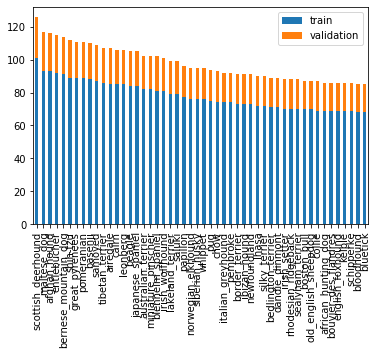

In [12]:
#graph representation 
data = y_train.value_counts().sort_index().to_frame()

data.columns = ['train']

data['validation']= y_validation.value_counts().sort_index().to_frame()

new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)

new_plot.plot(kind='bar', stacked=True)

plt.show()

In [13]:
#converting the train and validation labels into one hot format
y_train = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_validation=pd.get_dummies(y_validation.reset_index(drop=True)).as_matrix()

In [14]:
#train generator
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip='true')

train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=10, seed=10)

In [15]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = train_datagen.flow(x_validation, y_validation, shuffle=False, batch_size=10,seed=10)

***IncceptionV3***

In [16]:
base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(299,299,3))

W0925 09:27:45.124717 12816 deprecation_wrapper.py:119] From C:\Users\lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 09:27:52.081917 12816 deprecation_wrapper.py:119] From C:\Users\lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 09:27:53.989369 12816 deprecation_wrapper.py:119] From C:\Users\lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0925 09:27:55.706868 12816 deprecation_wrapper.py:119] From C:\Users\lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0925 09:27:55.742824 12816 deprecation_wrapper.py:1

In [17]:
#Global spatial average pooling layer
x= base_model.output
x=GlobalAveragePooling2D()(x)

In [18]:
#fully-connected layer and a logistsic layer with 50 classes
#(there will be 120 classes for the final submission)
x=Dense(512, activation='relu')(x)
predictions = Dense(50,activation="softmax")(x) 

In [19]:
#the model will train
model = Model(input = base_model.input, outputs = predictions)

In [20]:
#first: only training top layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
#compile with Adam
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

W0925 09:28:49.779562 12816 deprecation_wrapper.py:119] From C:\Users\lenovo\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [22]:
#Train the model
model.fit_generator(train_generator,steps_per_epoch=175,validation_data=val_generator,validation_steps=44,epochs=2,verbose=1)
model.save("retrained.h5")

W0925 09:28:54.462384 12816 deprecation.py:323] From C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
175/175 [==============================] - ETA: 57:19 - loss: 4.2037 - acc: 0.0000e+ - ETA: 32:30 - loss: 4.1391 - acc: 0.0000e+ - ETA: 24:03 - loss: 4.0818 - acc: 0.0000e+ - ETA: 19:49 - loss: 4.0583 - acc: 0.0000e+ - ETA: 17:25 - loss: 4.0400 - acc: 0.0000e+ - ETA: 15:46 - loss: 4.0129 - acc: 0.0000e+ - ETA: 14:37 - loss: 3.9685 - acc: 0.0000e+ - ETA: 13:45 - loss: 3.9627 - acc: 0.0125   - ETA: 13:06 - loss: 3.9546 - acc: 0.01 - ETA: 12:38 - loss: 3.9537 - acc: 0.01 - ETA: 12:15 - loss: 3.9724 - acc: 0.00 - ETA: 11:51 - loss: 3.9678 - acc: 0.00 - ETA: 11:32 - loss: 3.9602 - acc: 0.00 - ETA: 11:13 - loss: 3.9424 - acc: 0.00 - ETA: 10:57 - loss: 3.9466 - acc: 0.00 - ETA: 10:44 - loss: 3.9485 - acc: 0.01 - ETA: 10:30 - loss: 3.9428 - acc: 0.01 - ETA: 10:18 - loss: 3.9530 - acc: 0.01 - ETA: 10:07 - loss: 3.9450 - acc: 0.01 - ETA: 9:57 - loss: 3.9394 - acc: 0.0100 - ETA: 9:48 - loss: 3.9453 - acc: 0.009 - ETA: 9:38 - loss: 3.9354 - acc: 0.009 - ETA: 9:14 - loss: 3.9461 - acc: 0.

175/175 [==============================] - ETA: 8:33 - loss: 2.4750 - acc: 0.500 - ETA: 8:37 - loss: 2.8148 - acc: 0.400 - ETA: 8:47 - loss: 2.7597 - acc: 0.400 - ETA: 9:00 - loss: 2.6930 - acc: 0.450 - ETA: 8:57 - loss: 2.6728 - acc: 0.440 - ETA: 8:49 - loss: 2.6486 - acc: 0.466 - ETA: 8:43 - loss: 2.5861 - acc: 0.514 - ETA: 8:38 - loss: 2.5907 - acc: 0.525 - ETA: 8:39 - loss: 2.6029 - acc: 0.511 - ETA: 8:34 - loss: 2.5872 - acc: 0.510 - ETA: 8:30 - loss: 2.5861 - acc: 0.527 - ETA: 8:26 - loss: 2.5611 - acc: 0.533 - ETA: 8:22 - loss: 2.5993 - acc: 0.507 - ETA: 8:21 - loss: 2.6440 - acc: 0.500 - ETA: 8:16 - loss: 2.6353 - acc: 0.500 - ETA: 8:12 - loss: 2.6260 - acc: 0.512 - ETA: 8:08 - loss: 2.6200 - acc: 0.511 - ETA: 8:04 - loss: 2.6240 - acc: 0.505 - ETA: 8:01 - loss: 2.6034 - acc: 0.510 - ETA: 7:58 - loss: 2.5932 - acc: 0.515 - ETA: 7:54 - loss: 2.5868 - acc: 0.519 - ETA: 7:51 - loss: 2.5854 - acc: 0.509 - ETA: 7:47 - loss: 2.5751 - acc: 0.517 - ETA: 7:43 - loss: 2.5631 - acc: 0.520

In [23]:
from keras.applications.inception_v3 import preprocess_input
import cv2
image=cv2.imread("Cairn1.jpg")
arrayresized = cv2.resize(image,(299,299))
inputarray = arrayresized[np.newaxis,...]
im = preprocess_input(inputarray)
predict=model.predict(im)
y_classes = predict.argmax(axis=-1)
y_classes=max(y_classes)
print(top_breeds[y_classes])

cairn
